# South Korea notebook

This notebook contains all the Julia 1.4 code required to
characterize the propagation of CoViD19 as discussed in the main
notebook: _Population_dynamics.ipynb_

### Initialization, display LOAD_PATH at the end

In [1]:
push!(LOAD_PATH, pwd())
if ispath( pwd()*"/src")
    push!(LOAD_PATH, pwd()*"/src")
end


using SpecialFunctions, LaTeXStrings
using DataFrames, Query, CSV, Dates
using LsqFit

using MyFunctions, Mrate

using Plots
theme(:solarized_light)

┌ Info: Precompiling MyFunctions [top-level]
└ @ Base loading.jl:1260
┌ Info: Precompiling Mrate [top-level]
└ @ Base loading.jl:1260


["@", "@v#.#", "@stdlib", "/home/strix/mywork/12-pop_dynamics/public/PopulationDynamics", "/home/strix/mywork/12-pop_dynamics/public/PopulationDynamics/src"]


### Parametrization for the incubation times, source:
https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000062

In [2]:
μΓ, σΓ = 6.5, 2.6       # mean and standard deviation for incubation

αΓ( μ, σ ) = μ^2/σ^2    # [α] = 1  is a dimensionless parameter
βΓ( μ, σ ) = μ / σ^2    # [β] = 1/T has dimension of frequency

α0 = αΓ( μΓ, σΓ )
β0 = βΓ( μΓ, σΓ )

ρ0=[α0,β0]

2-element Array{Float64,1}:
 6.249999999999999
 0.9615384615384615

### load data and manipulate data

In [3]:
dset_origin = "/data.europa.eu"
dset_name = "6u83xREK"
worlddata = CSV.File( pwd()*dset_origin*"/"*dset_name ) |> DataFrame!

country_name = "South_Korea"
country = worlddata |> @filter(_.countriesAndTerritories==country_name
    ) |> DataFrame

dates = Date.( country[!,:dateRep], "d/m/y" )
population = country[1,:popData2018]

51635256

In [4]:
ordering = sortperm( dates );
dates_ordered = dates[ordering];
cases = country[!,:cases][ordering];
deaths = country[!,:deaths][ordering];

In [5]:
t_offset = dates_ordered[1];
Δt = dates_ordered -t_offset;
Δtv = Dates.value.( Δt );

In [6]:
cases_cum =  cumsum( cases );
deaths_cum =  cumsum( deaths );
n_cases = cases_cum/population;
n_deaths = deaths_cum/population;

ndata = n_cases;

#### visualize raw data

In [7]:
nM = 1.25 *maximum( ndata );
nm = 0.75 *minimum( ndata );

tm, tM = 1, maximum( Δtv ) +5;

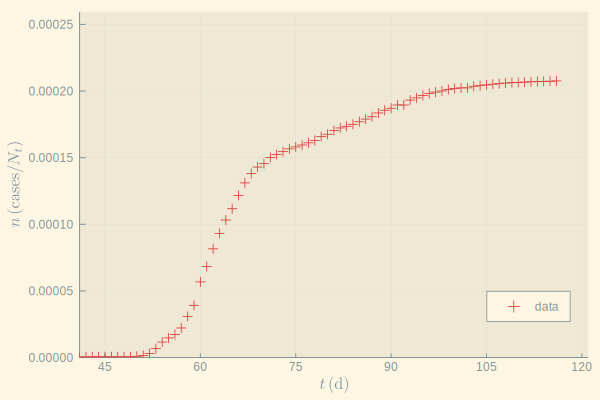

In [8]:
plot( Δtv, ndata, label="data"
    , markershape=:+, markersize=5, linealpha=0
    , legend=:bottomright )
plot!( xlabel = L"t \, \mathrm{(d)}",
    xlims = (41,tM), xticks = 45:15:tM )
plot!( ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (nm,nM)  )

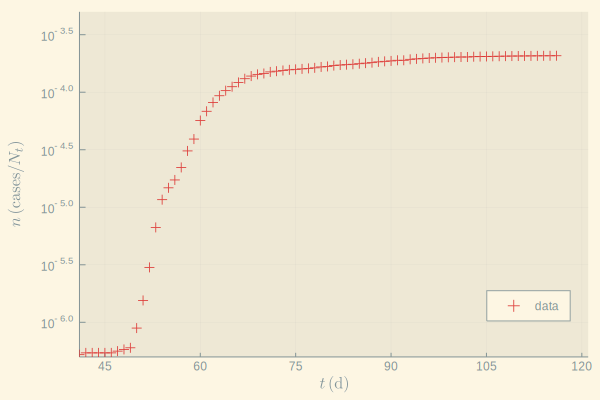

In [9]:
savefig("img/"*country_name*"_raw.svg")
plot!( yscale = :log10, ylims = (5*10^(-7.),5*10^(-4.)) )

In [10]:
savefig("img/"*country_name*"_raw_log.svg")
plot!( yscale = :auto, ylims = (nm,nM) );

### The models
__Note:__ parameter p[2] is not multiplied by p[1] as in the main notes. Here p[2] is dimensionless! To recover the definition used in the main text divide by p[1], ie t_0 = p[2]/p[1]

In [11]:
# simple logistic model
@. model0(t,p) = 1/( 1.0 +exp( -p[1]*t +p[2] ) )

model0 (generic function with 1 method)

In [12]:
# the m-steady state model and its Jacobian
# definitions of modelm, modelm_j and all other relevant functions
# at Mrate.jl and MyFunctions.jl

function m_m( t, p )
    modelm(t,p,ρ0)
end

function j_m(t::Array,p)
    J = Array{Float64}(undef, length(t), length(p))
    J = modelm_j(t, p, ρ0)
end

j_m (generic function with 1 method)

In [13]:
p0 = [0.25, 0. ];
x0 = [0, 1.0, 2.0];
@time model0(0.0, p0);
@time model0(x0, p0);
@time m_m(0.0,p0);
@time m_m(x0,p0);
@time j_m(x0,p0);

p2 = [0.25, 18.8, 0.0025, 45., 0.035, 65. ];
@time m_m(0.0,p2);
@time m_m(x0,p2);
@time j_m(x0,p2);

  0.071905 seconds (205.94 k allocations: 11.575 MiB)
  0.169890 seconds (613.69 k allocations: 30.853 MiB)
  0.482048 seconds (656.30 k allocations: 34.355 MiB, 5.53% gc time)
  0.104127 seconds (239.78 k allocations: 13.014 MiB)
  2.697727 seconds (4.71 M allocations: 256.125 MiB, 3.78% gc time)
  0.000008 seconds (2 allocations: 32 bytes)
  0.000009 seconds (1 allocation: 112 bytes)
  0.000016 seconds (32 allocations: 3.719 KiB)


### Nonlinear fits
#### The logistic fit

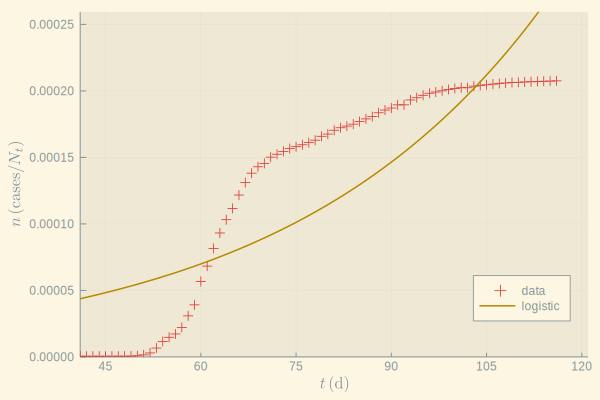

In [14]:
dm, dM = 1, length(Δtv)
fit0 = curve_fit( model0, Δtv[dm:dM], ndata[dm:dM], p0 )

tcont = range(Δtv[1],Δtv[end]*1.1; length=length(Δtv))
estimate0 = model0( tcont, fit0.param )
plot!( tcont, estimate0, label="logistic", linewidth=1.5 )


In [15]:
savefig("img/"*country_name*"_logistic.svg")


# truncate the dataset
dm, dM = 1, 66
p0 = [1., 80]

fit0b = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p0 )
estimate0b = m_m( tcont, fit0b.param );

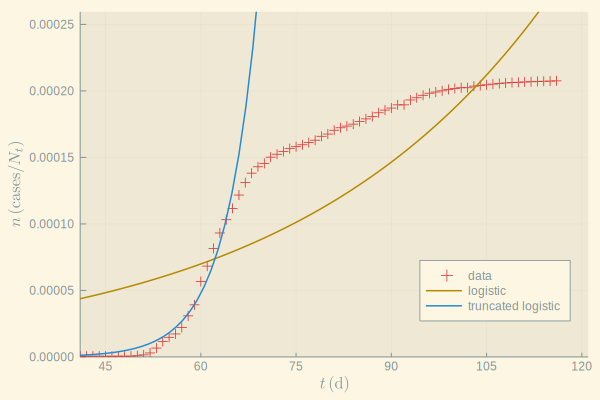

In [16]:
pstr = "truncated logistic"
plot!( tcont, estimate0b, label=pstr, linewidth = 1.5 )

#### two steady state model m=1

In [17]:
dm, dM = 1, length(Δtv)
p1 = [0.2, 15, 0.05, 70 ]
fit1 = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p1 )
estimate1 = m_m( tcont, fit1.param );

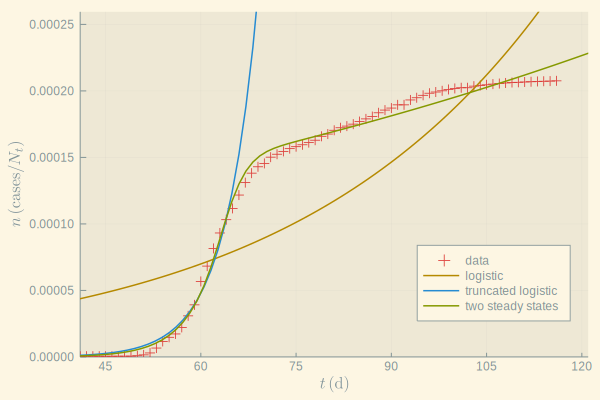

In [18]:
pstr = "two steady states"
plot!( tcont, estimate1, label=pstr, linewidth=1.5  )

In [19]:
dm, dM = 1, 100
p1 = [0.2, 15, 0.05, 70 ]
fit1b = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p1 )
estimate1b = m_m( tcont, fit1b.param );

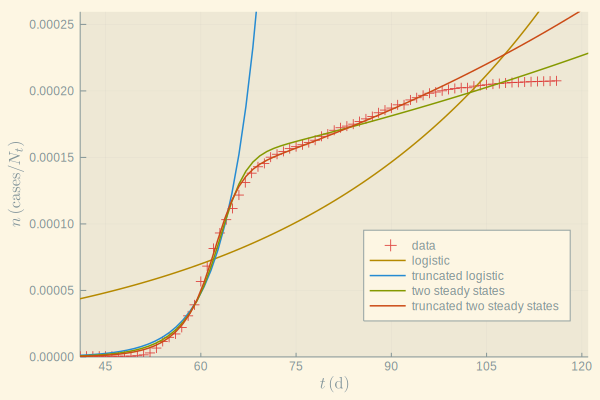

In [20]:
pstr = "truncated two steady states"
plot!( tcont, estimate1b, label=pstr, linewidth=1.5  )

#### three steady state m=2

In [21]:
dm, dM = 1, length(Δtv)
p2 = [0.25, 15, 0.01, 58, 0.005, 100 ]

lb = [ 0.1, 10, 0.005, 50, 0.00001, 80 ]
ub = [ 0.3, 1000, 0.1, 70, 0.1, 110 ]

fit2 = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p2;
    show_trace=true, lower=lb, upper=ub );

     0     3.549801e+01              NaN
 * lambda: 10.0

     1     1.764619e+01     3.512697e+02
 * g(x): 351.26969148969994
 * lambda: 1.0
 * dx: [-0.004688456180323042, 0.2899445869057953, -0.005, -1.5318595427894834, -0.0049900000000000005, -20.0]

     2     3.632139e+00     2.259677e+02
 * g(x): 225.96772255909278
 * lambda: 0.1
 * dx: [-0.0071447349743974375, 0.4472195442889788, 0.0, -1.8441370308950553, 4.0826988057657276e-19, 0.0]

     3     5.240944e-01     6.322884e+01
 * g(x): 63.22884375161267
 * lambda: 0.010000000000000002
 * dx: [-0.006866434353400563, 0.42429183521013414, 0.0, -1.4247988487280665, 0.0, 0.0]

     4     6.772088e-02     1.018688e+01
 * g(x): 10.186880818764891
 * lambda: 0.0010000000000000002
 * dx: [-0.007582920836669199, 0.4713758526097038, 0.0, -0.7612211016932733, 8.499431301669488e-6, 0.0]

     5     8.902635e-03     1.402820e+00
 * g(x): 1.402819974282123
 * lambda: 0.00010000000000000003
 * dx: [-0.00827676031833327, 0.5293675576089711, 6.3965

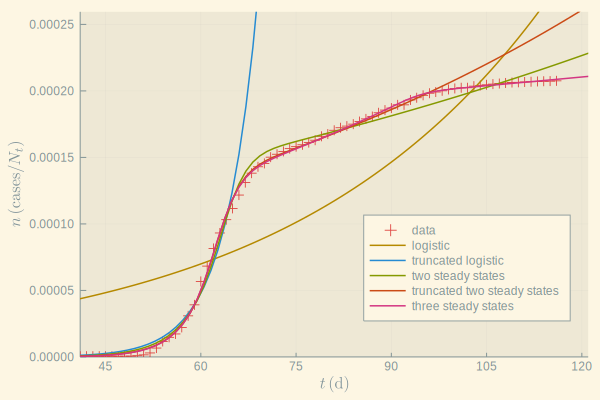

In [22]:
estimate2 = m_m( tcont, fit2.param )
pstr = "three steady states"
plot!( tcont, estimate2, label=pstr, linewidth=1.5)

In [23]:
savefig("img/"*country_name*"_fits_converged.svg")

##### Estimate quality of fit

In [24]:
cov_mat = estimate_covar(fit2)
sigma = stderror(fit2)

margin_of_error = margin_error(fit2, 0.05)
confidence_inter = confidence_interval(fit2, 0.05)

# display the parameters
round.( fit2.param; sigdigits=3 )'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.25  24.9  0.0122  57.5  0.00211  88.5

In [25]:
# estimate the margins of error
round.( sigma; sigdigits=3 )'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.00671  0.405  0.000265  0.124  0.000324  0.647

In [26]:
# estimate the margins of error
round.( margin_of_error; sigdigits=3 )'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.0133  0.802  0.000525  0.247  0.000641  1.28

In [27]:
# estimate the margins of error
confidence_inter

6-element Array{Tuple{Float64,Float64},1}:
 (0.23705421484152286, 0.2636395267997887)
 (24.11812198594244, 25.722135539510955)
 (0.01165740069487232, 0.012706651654743063)
 (57.26082903760031, 57.75419038245206)
 (0.0014644964322595567, 0.0027474728496188496)
 (87.2023947847147, 89.76563118353852)

In [28]:
# the covariance matrix estimate
round.( cov_mat; sigdigits=3 )

6×6 Array{Float64,2}:
  4.5e-5     0.00271   3.85e-7   -0.000734   5.27e-8  -0.000447
  0.00271    0.164     2.24e-5   -0.0436     3.07e-6  -0.026
  3.85e-7    2.24e-5   7.01e-8   -1.45e-5    1.46e-8  -0.000115
 -0.000734  -0.0436   -1.45e-5    0.0155    -2.07e-6   0.0174
  5.27e-8    3.07e-6   1.46e-8   -2.07e-6    1.05e-7  -0.00015
 -0.000447  -0.026    -0.000115   0.0174    -0.00015   0.418